In [10]:
from scipy import ndimage
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2

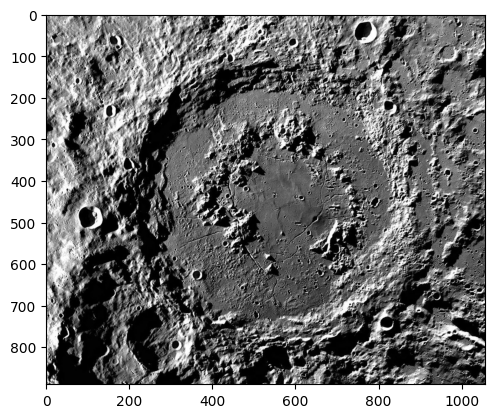

In [15]:
img = cv2.imread("/content/moon crater.jpg")          # link of the image : https://www.bing.com/images/search?view=detailV2&ccid=Ov82B2oL&id=3279A707A6C9C1483D4CA2C8DCDA01DFACB00030&thid=OIP.Ov82B2oLGuZkwqTZhj4QNQHaFf&mediaurl=https%3a%2f%2fwww.authcom.com%2fwp-content%2fuploads%2f2019%2f06%2f67068-thumb.jpg&exph=436&expw=588&q=crater+of+moon+image+in+jpg+format&simid=608022818182144469&FORM=IRPRST&ck=8418F20B31BC36516F5D98932EF759D6&selectedIndex=10
img = img.astype('int32')
plt.imshow(img,cmap = plt.get_cmap('gray'))
plt.show()


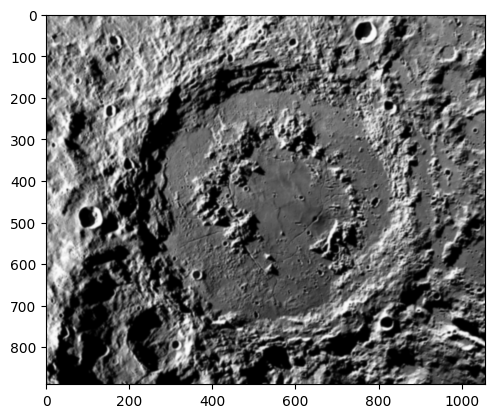

In [16]:
img_gaussian = ndimage.gaussian_filter(img,sigma=1.4)
plt.imshow(img_gaussian,cmap = plt.get_cmap('gray'))
plt.show()

In [17]:
from scipy.ndimage import sobel

In [18]:
def Normalize(img):
    #img = np.multiply(img, 255 / np.max(img))
    img = img/np.max(img)
    return img

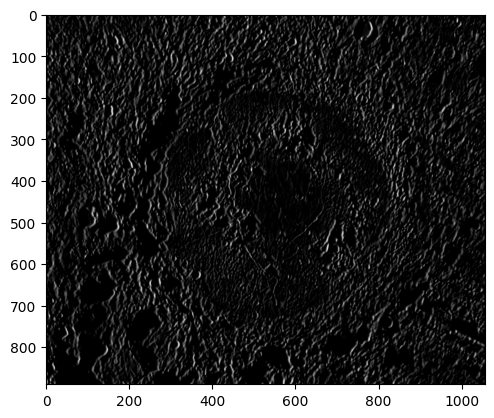

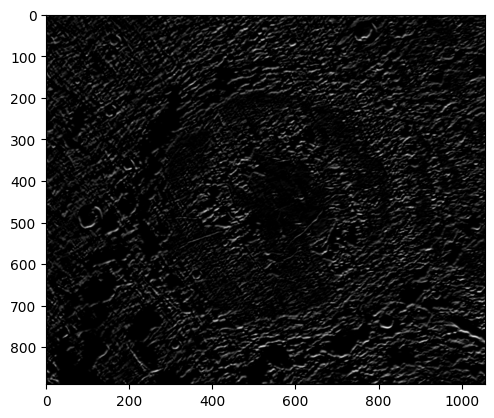

In [19]:
gx = sobel(img_gaussian,axis=1) # horizontal derivative
gx = Normalize(gx)
plt.imshow(gx,cmap = plt.get_cmap('gray'))
plt.show()
gy = sobel(img_gaussian,axis=0) # vertical derivative
gy = Normalize(gy)
plt.imshow(gy,cmap=plt.get_cmap('gray'))
plt.show()

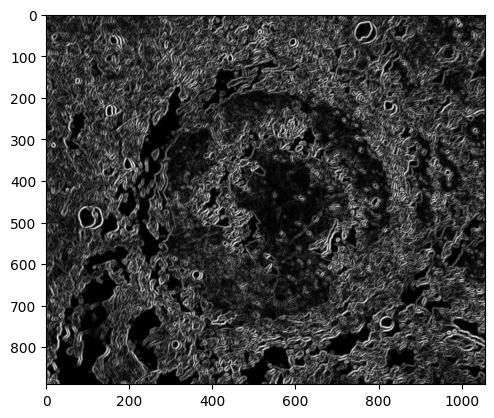

In [20]:
Mag = np.hypot(gx,gy)
plt.imshow(Mag,cmap = plt.get_cmap('gray'))
plt.show()


In [21]:
Gmat = np.degrees(np.arctan2(gy,gx))
Gmat

array([[[ 158.54656341,  158.54656341,  158.54656341],
        [ 177.32189016,  177.32189016,  177.32189016],
        [-179.6301914 , -179.6301914 , -179.6301914 ],
        ...,
        [-146.46920991, -146.46920991, -146.46920991],
        [-146.46920991, -146.46920991, -146.46920991],
        [-127.03587836, -127.03587836, -127.03587836]],

       [[ 142.76122742,  142.76122742,  142.76122742],
        [ 172.34966752,  172.34966752,  172.34966752],
        [ 178.0245545 ,  178.0245545 ,  178.0245545 ],
        ...,
        [-123.1819351 , -123.1819351 , -123.1819351 ],
        [-120.73076948, -120.73076948, -120.73076948],
        [-105.55022073, -105.55022073, -105.55022073]],

       [[ 143.13558193,  143.13558193,  143.13558193],
        [ 167.51290002,  167.51290002,  167.51290002],
        [ 171.06193302,  171.06193302,  171.06193302],
        ...,
        [-124.11932043, -124.11932043, -124.11932043],
        [-119.03295446, -119.03295446, -119.03295446],
        [-103.47055701

In [22]:


def non_max_suppression(gradient_magnitude, gradient_direction):
    rows, cols, _ = gradient_direction.shape
    suppressed = np.zeros_like(gradient_magnitude)

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            angle = gradient_direction[i, j, 0]

            # Determine the neighboring pixels to compare against
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                neighbor1 = gradient_magnitude[i, j + 1]
                neighbor2 = gradient_magnitude[i, j - 1]
            elif 22.5 <= angle < 67.5:
                neighbor1 = gradient_magnitude[i - 1, j - 1]
                neighbor2 = gradient_magnitude[i + 1, j + 1]
            elif 67.5 <= angle < 112.5:
                neighbor1 = gradient_magnitude[i - 1, j]
                neighbor2 = gradient_magnitude[i + 1, j]
            else:
                neighbor1 = gradient_magnitude[i - 1, j + 1]
                neighbor2 = gradient_magnitude[i + 1, j - 1]

            # Perform non-maximal suppression
            suppressed[i, j] = np.maximum(np.maximum(neighbor1, neighbor2), gradient_magnitude[i, j])

    return suppressed


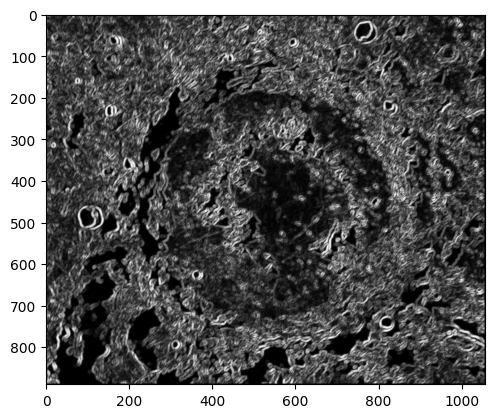

In [23]:
img_NMS = non_max_suppression(Mag,Gmat)
img_NMS  = Normalize(img_NMS)
plt.imshow(img_NMS,cmap = plt.get_cmap('gray'))
plt.show()


In [24]:
def double_threshold_hysteresis(image, low_threshold, high_threshold):
    # Convert image to grayscale if it's in color
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)

    # Create a copy of the input image
    output = np.zeros_like(image, dtype=np.uint8)

    # Apply double thresholding
    strong_pixels = (image >= high_threshold)
    weak_pixels = (image >= low_threshold) & (image < high_threshold)

    # Assign pixel values based on thresholds
    output[strong_pixels] = 255
    output[weak_pixels] = 128

    # Perform connectivity analysis to strengthen weak edges
    height, width = output.shape
    for y in range(1, height - 1):
        for x in range(1, width - 1):
            if output[y, x] == 128:
                if np.any(output[y - 1:y + 2, x - 1:x + 2] == 255):
                    output[y, x] = 255
                else:
                    output[y, x] = 0

    return output

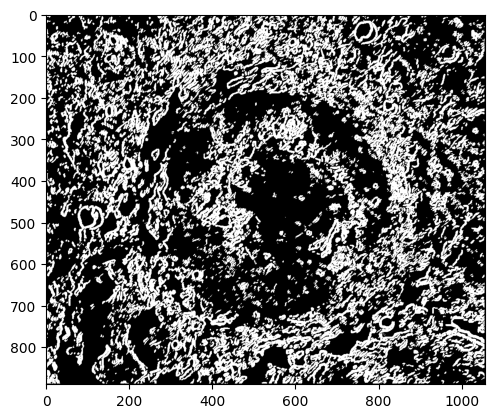

In [25]:
final_img = double_threshold_hysteresis(img_NMS,.30,.32)
plt.imshow(final_img,cmap = plt.get_cmap('gray'))
plt.show()

In [26]:
def pad_image(image, pad_width):
    # Apply padding to the image
    padded_image = np.pad(image, pad_width, mode='constant', constant_values=0)
    return padded_image

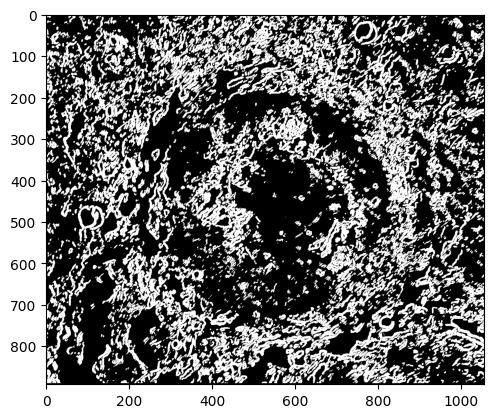

In [27]:
ed_img = pad_image(final_img,1)  # final edge detected image after applying padding.
plt.imshow(ed_img,cmap = plt.get_cmap('gray'))
plt.show()